Hysteresis loop area = 4.956e-06 V·A

Memristor simulation summary
─────────────────────────────
 Drive amplitude ±2.20 V @ 0.050 Hz  (4 cycles)
 Peak current        = 0.24 mA
 State range (w)     = 0.329 → 0.495   (Δ = 0.166)
 Dynamic R_OFF/R_ON  ≈   1.3:1
 Loop area           = 0.005 V·mA
─────────────────────────────



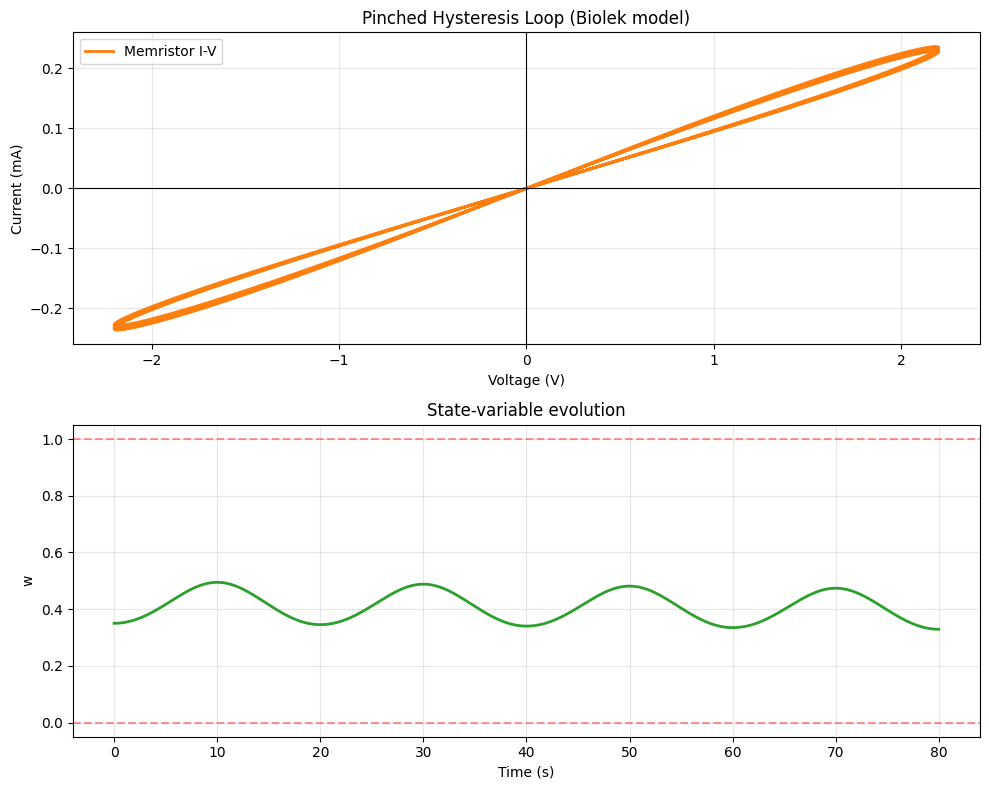

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class BiolekMemristor:
    def __init__(self, Ron=100, Roff=16_000,
                 D=10e-9,
                 uv=1e-16,       # ← key change: much slower ions
                 p=2,            # ← window less steep so RESET can pull back
                 w_init=0.35):   # start away from the rails
        self.Ron, self.Roff = Ron, Roff
        self.k   = uv * Ron / D**2          # drift constant
        self.p   = p
        self.w0  = np.clip(w_init, 0., 1.)

    def _window(self, w, I):
        # polarity-aware Biolek window
        return 1. - (w - 1.)**(2*self.p) if I >= 0 else 1. - w**(2*self.p)

    def _R(self, w):
        w = np.clip(w, 0., 1.)
        return self.Ron*w + self.Roff*(1. - w)

    def simulate(self, t, v_func):
        dt   = t[1] - t[0]
        w    = np.empty_like(t); w[0] = self.w0
        v,i  = np.empty_like(t), np.empty_like(t)

        for k in range(len(t) - 1):
            v[k] = v_func(t[k])
            i[k] = v[k] / self._R(w[k])
            dw   = self.k * i[k] * self._window(w[k], i[k])
            w[k+1] = np.clip(w[k] + dw*dt, 0., 1.)

        v[-1] = v_func(t[-1]); i[-1] = v[-1] / self._R(w[-1])
        return v, i, w


# ──────────────────────────────────────────────
# 2.  Drive settings: moderate amplitude, low freq
# ──────────────────────────────────────────────
if __name__ == '__main__':
    mem = BiolekMemristor(uv = 1e-16, p = 3, w_init=0.35)
    f      = 0.05
    Vpk    = 2.2
    dt     = 1e-3          # 1 ms step
    periods = 4
    Tsim   = periods / f

    t   = np.arange(0, Tsim + dt, dt)
    vfn = lambda τ: Vpk * np.sin(2*np.pi*f*τ)

    v, i, w = mem.simulate(t, vfn)
    i_mA    = i * 1e3

    # shoelace area in V·A  (multiply by 1e3² for V·mA if you like)
    area = 0.5 * abs(np.dot(v, np.roll(i, -1)) - np.dot(i, np.roll(v, -1)))
    print(f"Hysteresis loop area = {area:.3e} V·A")

    # ---------------- post-processing numbers ----------------
    peak_I   = np.max(np.abs(i))           # A
    R_dyn    = (mem._R(w)).max() / (mem._R(w)).min()
    w_span   = w.max() - w.min()

    area_VA  = 0.5 * abs(np.dot(v, np.roll(i, -1)) - np.dot(i, np.roll(v, -1)))
    area_mVA = area_VA * 1e3

    print("\nMemristor simulation summary")
    print("─────────────────────────────")
    print(f" Drive amplitude ±{Vpk:.2f} V @ {f:.3f} Hz  ({periods} cycles)")
    print(f" Peak current        = {peak_I*1e3:.2f} mA")
    print(f" State range (w)     = {w.min():.3f} → {w.max():.3f}   (Δ = {w_span:.3f})")
    print(f" Dynamic R_OFF/R_ON  ≈ {R_dyn:5.1f}:1")
    print(f" Loop area           = {area_mVA:.3f} V·mA")
    print("─────────────────────────────\n")
    # ────────── plots ──────────
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(v, i_mA, color='tab:orange', lw=2, label='Memristor I-V')
    ax1.set(title='Pinched Hysteresis Loop (Biolek model)',
            xlabel='Voltage (V)', ylabel='Current (mA)')
    ax1.axhline(0, color='k', lw=.8); ax1.axvline(0, color='k', lw=.8)
    ax1.grid(alpha=.3); ax1.legend()

    ax2.plot(t, w, color='tab:green', lw=2)
    ax2.set(title='State-variable evolution', xlabel='Time (s)', ylabel='w')
    ax2.axhline(0, color='r', ls='--', alpha=.4)
    ax2.axhline(1, color='r', ls='--', alpha=.4)
    ax2.grid(alpha=.3)

    plt.tight_layout()
    plt.show()
